# Self Study 10: Coupled Cobweb Dynamics

As you learned in this weeks lecture, the traditional cobweb model describe a dynamic price adjustment process for a single non-storable good with a supply response lag.
In this exercise we will explore an extension of model in which producers may chose which of two market to sell in. In this extended model the decision to enter one of two markets is repeated in every period. Specifically and is based on the profits of the preceding period.

The self study is structured as follow:

1. We look at this model assuming there is no interaction between the two markets and derive the price update rule.
2. We introduce the idea that firms can chose which market to sell in based on the profits of the preceding period.
3. Finally, given this update rule we will simulate the model.


Note we will use some Object Oriented Programming (OOP) to make the code more readable; if you are not familiar with OOP, don't worry, you can still follow the tutorial.


### The Model

Consider two markets $X$ and $Y$ and there is a fixed number ($N$). In each round a fraction $W_{Xt}$ is active in market $X$ and a fraction $W_{Yt}$ in market $Y$.

**Changes from Lecture:**
For notation simplicity I will use $i$ to denote either of the two markets, and $j$ to denote the other.
So for example the share of suppliers in market $i$ is $W_{it}$ and that of $j$ is $W_{jt} = 1- W_{it}$.
Also unlike in the lecture I will assume that $N=1$; this has no effect on the results. 


In each period the market clears, which means that demand and equals supply weighted by the share of suppliers in each market,
$$
D_{it} = W_{it} S_{it} \qquad \forall i \in \{X,Y\}
$$


As in the basic cobweb model, we assume that the supply response is lagged.
In other words supply in market $i$ at $t$ depends on the price observed in the previous period $P_{it-1}$ and is given by:

$$
S_{it} = \frac{P_{it-1}-c_i}{d_i}
$$
    
where $c_i$ and $d_i$ are constants.
Demand in market $i$ on the other hand depends on the current $P_{it}$ and is given by:

$$
D_{it} = \frac{a_i - P_{it}}{b_i}
$$

where again $a_i$ and $b_i$ are constants.

Here is some code for the following tasks, continue reading after it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

In [2]:
### CODE PROVIDED, NO NEED TO CHANGE ###
def plot_cobweb(fun, x0, n, plot_range=(0, 1), **f_kwargs):
    """
    Plot the cobweb plot for a function f, starting point x0, and number of steps n.

    Args:
        f (function): Function of the form f(x, **f_kwargs), where x is a float and f_kwargs are additional keyword arguments.
        x0 (float): Initial value.
        n (int): Number of iterations.
        **f_kwargs: Additional keyword arguments to pass to f.
    """
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    x = np.linspace(plot_range[0], plot_range[1], 500)
    y = fun(x, **f_kwargs)
    ax.plot(x, y, "blue", lw=1, label="$f$")
    ax.plot(x, x, "gray", lw=0.5, label="Identity line", linestyle="dashed")

    x_n = x0
    for _ in range(n):
        y_n = fun(x_n, **f_kwargs)
        ax.plot([x_n, x_n], [x_n, y_n], "r", lw=1)
        ax.plot([x_n, y_n], [y_n, y_n], "r", lw=1)
        x_n = y_n

    ax.set_xlabel("x")
    ax.set_ylabel("f(x)")
    ax.legend()
    ax.grid(False)
    plt.show()

## Section 1: Decoupled markets

To start exploring this extended model we look first at it as if there was no interaction between the two markets. In other words, the price in market $i$ is not affected by the price in market $j$ and the proportion of consumers $W_{it}$ is given.

### Task 1: Find the price updating rule

Given the specification for the model find the price updating rule for market $i$, given the market clearing condition. Use either `sumpy` or derive analytically.

In [3]:
import sympy as sp

# define symbols
a, b, c, d, t = sp.symbols("a b c d t", positive=True)
P = sp.Function("P")
W = sp.Function("W")

demand_eqn = (a - P(t)) / b
supply_eqn = W(t) * (P(t-1) - c) / d

market_clearing_eqn = sp.Eq(demand_eqn, supply_eqn)


sol = sp.solve(market_clearing_eqn, P(t))

del a, b, c, d, P, t, W # clean up namespace

sol[0]

(a*d + b*c*W(t) - b*P(t - 1)*W(t))/d

In [4]:
def next_price_base(price_tm1, a, b, c, d, W_t):
    return a - b / d * W_t * (price_tm1 - c)

### Task 2: Plot the price updating rule using the Cobweb diagram

With the code from last lecture (also provided above) plot the price updating for various values of the parameters and explain how $b_i$ and $d_i$ affect the stability of the model.

In [5]:
# suggested initial parameters
base_params = dict(a=25, b=5, c=2, d=5.9, W_t=1)

# hint you can pass keyword arguments to a function using the ** notation (see `**f_kwargs` in `plot_cobweb`)

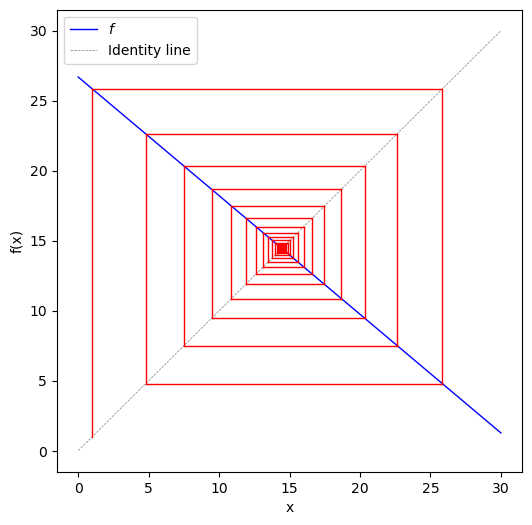

In [6]:
plot_cobweb(next_price_base, 1, n=50, plot_range=(0, 30), **base_params)

## Section 2: Coupled markets

As long as there is no interaction between the two markets we could look at them individually.
Now we allow producers to choose which market to enter.
Specifically we assume that producers prefer the more profitable market as observed in the last period.

To fully define this idea we need to define two things:
1. The profits in each market
2. The probability of entering each market

#### Profits

Profits at time $t$ are as always given by revenue minus costs. Revenue we can already compute: price times quantity sold. The cost on the other hand we need to define. We will assume that cost to be a quadratic function of the quantity sold.

$$
C_i(S_{it}) = c_i S_{it} + e_i S_{it}^2 
$$

where $e_i$ is a constant. We will assume that $e_i > 0$.

This than gives us the profits in each market

$$
\pi_{it} = P_{it} S_{it} - C_i(S_{it})
$$

#### Probability to a market

Given the profits in each market and the assumption that producers prefer the more profitable market we could assume that producers always enter the market which is most profitable $\argmax_i \{\pi_{it}\}$. However, this would lead to a very boring model. Instead we will assume that producers are not perfectly rational or that they are not perfectly informed. We will assume that producers enter market $i$ with the following probability:

$$
\begin{align}
\Pr(i| \pi_{it}, \pi_{jt}) &= \frac{\exp(f \times \pi_{it})}{\exp(f \times \pi_{it}) + \exp(f \times \pi_{jt})} \\
\Pr(j| \pi_{it}, \pi_{jt}) &= 1 - \Pr(i| \pi_{it}, \pi_{jt})
\end{align}
$$



### Task 1: Define market choice probability function and plot

Make a plot of the switching probability by changing the profits in market $i$ and keeping the profits in market $j$ constant and changing the switching parameter $f$.



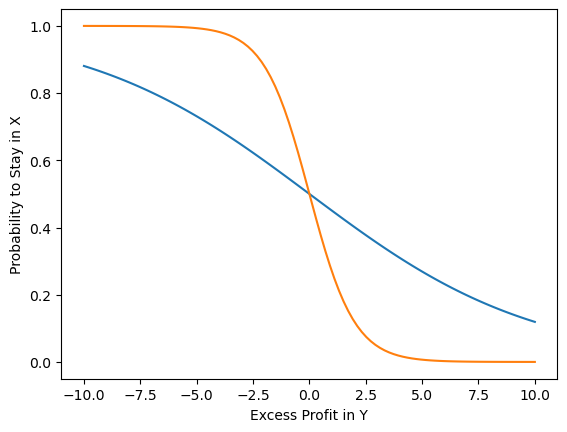

In [7]:
def prob_market(profit_X, profit_Y, f):
    return np.exp(f * profit_X) / (np.exp(f * profit_X) + np.exp(f * profit_Y))


def plot_and_show(f):
    profit_difference = np.linspace(-10, 10, 100)
    plt.plot(profit_difference, prob_market(0, profit_difference, f))
    plt.ylabel("Probability to Stay in X")
    plt.xlabel("Excess Profit in Y")


# interact(plot_and_show, f=(0, 2, 0.1))
plot_and_show(0.20)
plot_and_show(1.0)

**Question:** What is the meaning of the switching parameter $f$?

**Answer:** The switching parameter $f$ determines how sensitive producers are to difference in profits. The higher $f$ the more likely a producers will switch to the more profitable market.

### Task 2: Derive coupled price updating rule 

Remember the market clearing condition from earlier:

$$
D_{it} = W_{it} \times S_{it} \qquad \forall i \in \{X,Y\}
$$

Here $W_{it}$ is the share of producers in market $i$. In section 1 we assumed $W_{it}$ to independent of $j$, now it depends on the profits in both markets.
Since every producer has to be in one of the two markets we have that $W_{it} + W_{jt} = 1$.
Moreover, producers choose independently of the market they served previously and hance we can say: $W_{it} = \Pr(i | \pi_{it-1}, \pi_{jt-1})$.
In other words the share of producers in market $i$ is the probability of entering market $i$ given the previously observed profits in both markets.

Now, starting from the price updating rule you found earlier, derive the price updating rule with switching.

**ANSWER**

Plugging this into the market clearing condition we get:

$$
D_{it} = \Pr(i | \pi_{it-1}, \pi_{jt-1}) \times S_{it}
$$

$$
P_{it} = a_i - \frac{b_i}{d_i} \times \Pr(i | \pi_{it-1}, \pi_{jt-1}) \times (P_{it-1}-c_i)
$$

$$
P_{it} = a_i - \frac{b_i}{d_i} \times \frac{\exp(f \times \pi_{i,t-1})}{\exp(f \times \pi_{i,t-1}) + \exp(f \times \pi_{jt-1})} \times (P_{i,t-1}-c_i)

#### Task 3: Add the price update function to the Simulation

Because the implementation of this model requires some new programming concepts I provide a partial solution.
However, you still need to add a few things. 

I have left out the implementation of a few things: 

1. The definition of the `supply` function. 
2. The price updating rule you derived above.
3. The cost function, which is a quadratic function of the quantity sold (see above).
4. The profit calculation.

Look below for `# YOUR CODE HERE` in the `Market` class.

Note that you should read and understand both `Market` and `World` classes to understand how such a model may be simulated.
If you are new to OOP, you should still be able to solve this task.

In future exercises you may be asked to implement a larger part of the model yourself.

In [8]:
class Market:
    """
    Represents a market with dynamic pricing and producer population.

    Attributes:
        a, b, c, d, e: Parameters for demand, supply, and cost functions.
        price_history: A list storing the history of prices in the market.
        pop_history: A list storing the history of producer proportions in the market.
        quantity_history: A list storing the history of quantities supplied in the market.
    """

    def __init__(self, a, b, c, d, e, init_pop=1.0, initial_price=1):
        """Initialize the market with given parameters."""
        self.a: float = a
        self.b: float = b
        self.c: float = c
        self.d: float = d
        self.e: float = e

        # Initialize price history and store values for plotting
        self.price_history: list[float] = [initial_price]
        self.pop_history: list[float] = [init_pop]
        self.quantity_history: list[float] = [self.supply(initial_price)]

    def supply(self, price) -> float:
        """Calculate the supply at the last available price"""
        c, d = self.c, self.d
        return (price - c) / d  # TODO: YOUR CODE HERE

    def cost(self, quantity) -> float:
        """Calculate the cost of producing a given quantity."""
        c, e = self.c, self.e  # TODO: YOUR CODE HERE
        return c * quantity + e * quantity**2

    def calculate_profit(self) -> float:
        """Calculate the profit at the last available price."""
        p_tm1 = self.price_history[-2]  # price at t-1
        p_t = self.price_history[-1]  # price at t

        # TODO: YOUR CODE HERE

        qt = self.supply(p_tm1)  # note that supply depends on price at t-1
        revenue = p_t * qt
        cost = self.cost(qt)
        return revenue - cost

    def update_producer_proportions(self, other_market, f: float):
        """Update the proportion of producers in the market."""
        profit_self = self.calculate_profit()
        profit_other = other_market.calculate_profit()
        pop = prob_market(profit_self, profit_other, f)

        # record value for plotting
        self.pop_history.append(pop)

    def next_price(self):
        last_price = self.price_history[-1]
        current_pop = self.pop_history[-1]

        a, b, c, d = self.a, self.b, self.c, self.d
        # TODO: Implement the logic to calculate the next price in the market.
        next_price = next_price_base(last_price, a, b, c, d, current_pop)

        # record value for plotting
        self.price_history.append(next_price)
        self.quantity_history.append(self.supply(last_price))


class World:
    def __init__(self, market_X, market_Y, f):
        self.market_X: Market = market_X
        self.market_Y: Market = market_Y
        self.f = f

    def step(self):
        # compute curren periods market clearing prices
        self.market_X.next_price()
        self.market_Y.next_price()

        # given new prices let producers chose their market
        self.market_X.update_producer_proportions(self.market_Y, self.f)
        self.market_Y.update_producer_proportions(self.market_X, self.f)

    def simulate(self, n):
        for _ in range(n):
            self.step()

    ### CODE ONLY FOR PLOTTING, NO NEED TO CHANGE ###
    def plot_price_history(self, ax):
        ax.plot(self.market_X.price_history, label="Market X")
        ax.plot(self.market_Y.price_history, label="Market Y")
        ax.set_ylabel("Price")

    def plot_quantity_history(self, ax):
        ax.plot(self.market_X.quantity_history, label="Market X")
        ax.plot(self.market_Y.quantity_history, label="Market Y")
        ax.set_ylabel("Quantity")

    def plot_price_vs_price(self, ax):
        ax.scatter(self.market_X.price_history, self.market_Y.price_history, marker=".")
        ax.set_xlabel("Price in X")
        ax.set_ylabel("Price in Y")

    def plot_price_vs_stock(self, ax):
        mX, mY = self.market_X, self.market_Y
        ax.scatter(
            mX.price_history,
            mX.quantity_history,
            label="Market X",
            marker=".",
        )
        ax.scatter(
            mY.price_history,
            mY.quantity_history,
            label="Market Y",
            marker="o",
        )
        ax.set_xlabel("Price")
        ax.set_ylabel("Quantity")

    def plot_pop(self, ax):
        ax.plot(self.market_X.pop_history, label="Market X")
        ax.plot(self.market_Y.pop_history, label="Market Y")
        ax.set_ylabel("Proportion of Producers")

    def plot_pop_vs_price(self, ax):
        ax.scatter(
            self.market_X.pop_history, self.market_X.price_history, label="Market X"
        )
        ax.scatter(
            self.market_Y.pop_history, self.market_Y.price_history, label="Market Y"
        )
        ax.set_xlabel("Proportion of Producers")
        ax.set_ylabel("Price")

## Section 3: Explore the model

I provide two functions to plot the behaviour of the system `plot_symmetric_system` and `plot_asymmetric_system` (note the subtle `a` in `asymmetric`).

### Task 1: Explore the model and answer the questions below

Assume symmetric markets, i.e., both markets share the same parameters. 

1. Plot the system for these parameters: `a=20, b=6, c=2, d=8, e=1, f=0.17`.
2. Change the intensity of choice to `f = 0.20`, and explain what happens.
3. What happens in the extreme cases when `f = 0 and f → ∞`?

In [9]:
def plot_asymmetric_system(aX, bX, cX, dX, eX, aY, bY, cY, dY, eY, f, n):
    initial_price_X, initial_price_Y = 15, 14
    m1 = Market(aX, bX, cX, dX, eX, init_pop=0.5, initial_price=initial_price_X)
    m2 = Market(aY, bY, cY, dY, eY, init_pop=0.5, initial_price=initial_price_Y)
    w = World(m1, m2, f=f)

    w.simulate(n)
    fig, axs = plt.subplots(3, 2, figsize=(10, 10))
    w.plot_price_history(axs[0][0])
    w.plot_quantity_history(axs[1][0])
    w.plot_pop(axs[2][0])

    w.plot_price_vs_stock(axs[0][1])
    axs[0][1].legend()
    w.plot_price_vs_price(axs[1][1])
    w.plot_pop_vs_price(axs[2][1])


def plot_symmetric_system(a, b, c, d, e, f, n):
    plot_asymmetric_system(a, b, c, d, e, a, b, c, d, e, f, n)

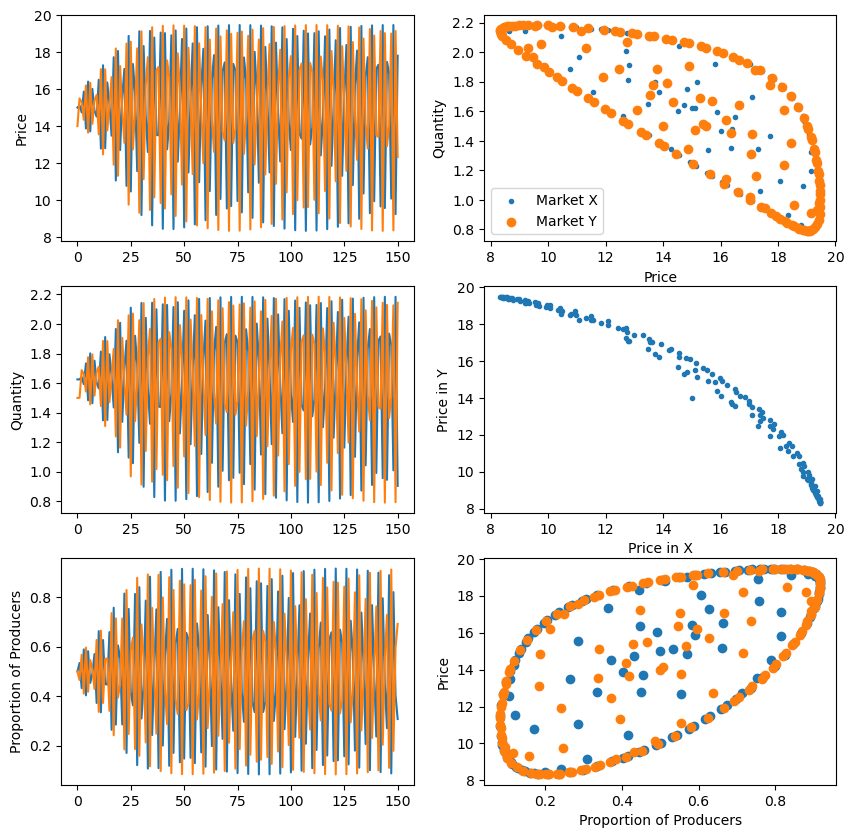

In [10]:
plot_symmetric_system(a=20, b=6, c=2, d=8, e=1, f=0.20, n=150)

### Task 2: Asymmetric markets

Now assume asymmetric markets, i.e., the markets have different parameters.
Specifically explore how differences in the cost function affect the dynamics of the system, i.e., change $e$.

**Question:** What happens when $e$ is very large?

**Answer:** When $e$ is very large all producers to move to the market with the lower cost of production.

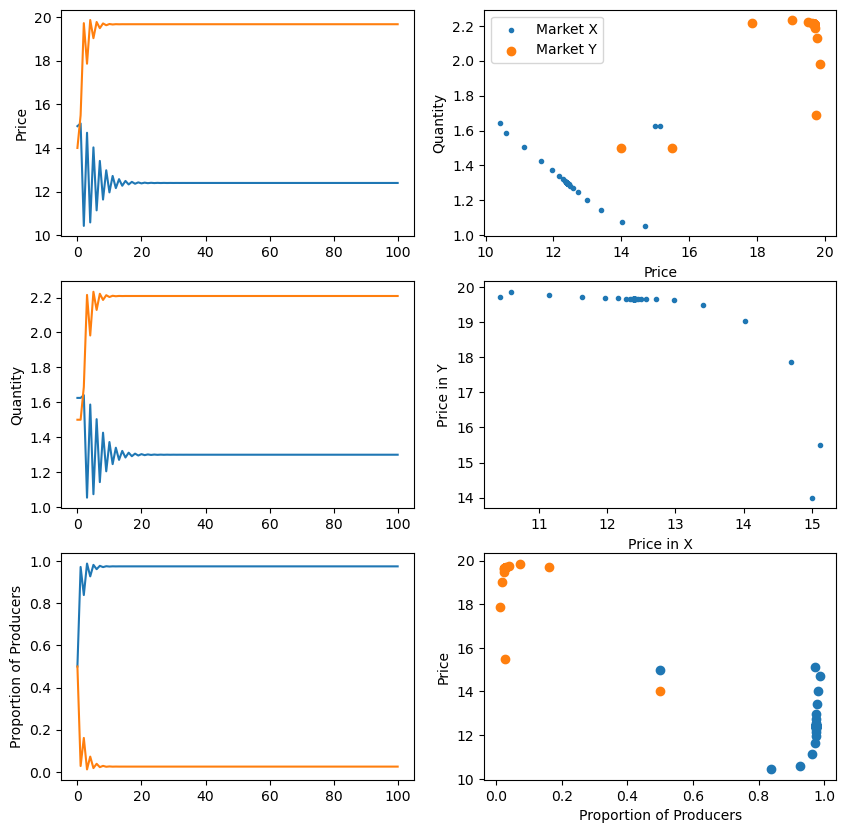

In [11]:
plot_asymmetric_system(
    aX=20,
    bX=6,
    cX=2,
    dX=8,
    eX=1,
    aY=20,
    bY=6,
    cY=2,
    dY=8,
    eY=10,
    f=0.17,
    n=100,
)

### Task 3: Create a bifurcation diagram

Similar to the approch we have used in the last tutorial to plot the bifurcation diagram of the lgoistic map, apply this here to this simulation. Plot the the last `m` prices in a simulation for values of $f$ between 0 and 0.6.

General steps are:

1. Create a function that returns the last `m` prices for one of the two markets for a given $f$
2. Iteratively extract these and plot the points and store
3. Plot these points in the $f$-Price plane


**Question**: Explain what you observe.

In [12]:
## Bifurcation Diagram
def prices_at_f(f, n_sim, m_last):
    m1 = Market(a=20, b=6, c=2, d=8, e=1, init_pop=0.3, initial_price=15)
    m2 = Market(a=20, b=6, c=2, d=8, e=1, init_pop=0.7, initial_price=17)
    w = World(m1, m2, f=f)

    w.simulate(n_sim)
    return m1.price_history[-m_last:]

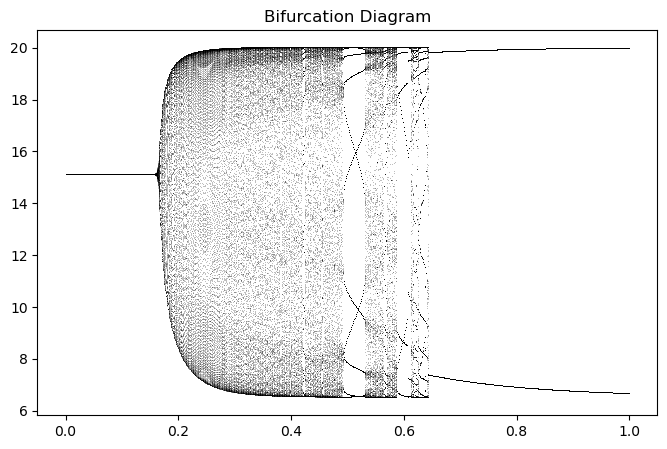

In [13]:
def plot_bifurcation(func, f_values, n, m):
    """
    Plot the bifurcation diagram for the logistic map.

    Parameters:
        func (function): The function to iterate over, it needs to have the signature func(r, n, m).
        f_values (array-like): An array of parameters to iterate over.
        n (int): The total number of iterations per r value.
        last (int): The number of iterations to plot to show long-term behavior.
    """
    # Initialize the array to hold the data points to plot
    r_points = []
    P_points = []

    for f in f_values:
        P = func(f, n, m)

        r_points.extend([f] * m)
        P_points.extend(P)

    # Plot the bifurcation diagram
    plt.figure(figsize=(8, 5))
    plt.plot(r_points, P_points, ",k", alpha=0.25)
    plt.title("Bifurcation Diagram")
    plt.show()


f_values = np.linspace(0, 1, 800)
plot_bifurcation(prices_at_f, f_values, 400, 200)

#### Task 4: Create a bifurcation diagram for $e$ and also other parameters (Optional)

Using the same approach as above, create a bifurcation diagram for $e$.

Hint: Just adapt the function from above to take $e$ as an argument instead of $f$.

In [14]:
## Bifurcation Diagram
def prices_at_e(e, n_sim, m_last):
    m1 = Market(a=20, b=6, c=2, d=8, e=e, init_pop=0.3, initial_price=15)
    m2 = Market(a=20, b=6, c=2, d=8, e=e, init_pop=0.7, initial_price=17)
    w = World(m1, m2, f=.17)

    w.simulate(n_sim)
    return m1.price_history[-m_last:]

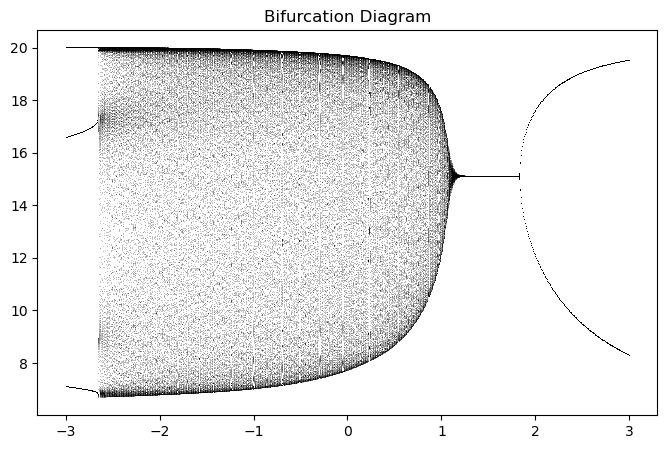

In [15]:
e_values = np.linspace(-3, 3, 800)
plot_bifurcation(prices_at_e, e_values, 400, 200)

In [16]:
## Bifurcation Diagram
def prices_at_c(c, n_sim, m_last):
    m1 = Market(a=20, b=6, c=c, d=8, e=1, init_pop=0.5, initial_price=15)
    m2 = Market(a=20, b=6, c=c, d=8, e=1, init_pop=0.5, initial_price=14)
    w = World(m1, m2, f=.17)

    w.simulate(n_sim)
    return m1.price_history[-m_last:]

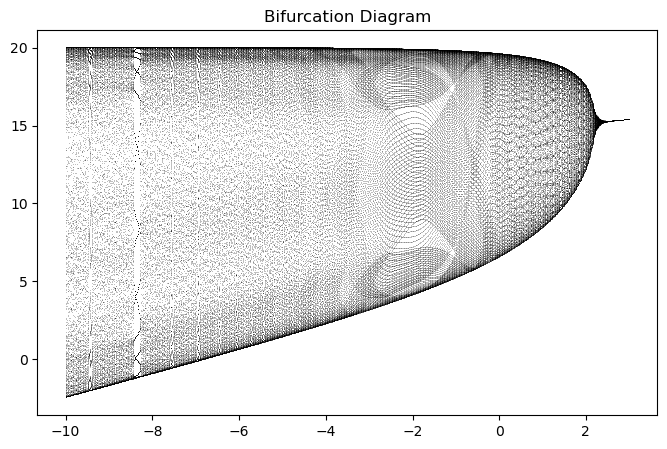

In [17]:
c_values = np.linspace(-10, 3, 800)
plot_bifurcation(prices_at_c, c_values, 400, 200)

In [18]:
## Bifurcation Diagram
def prices_at_e(e, n_sim, m_last):
    m1 = Market(a=20, b=6, c=2, d=8, e=e, init_pop=0.5, initial_price=15)
    m2 = Market(a=20, b=6, c=2, d=8, e=e, init_pop=0.5, initial_price=14)
    w = World(m1, m2, f=.17)

    w.simulate(n_sim)
    return m1.price_history[-m_last:]

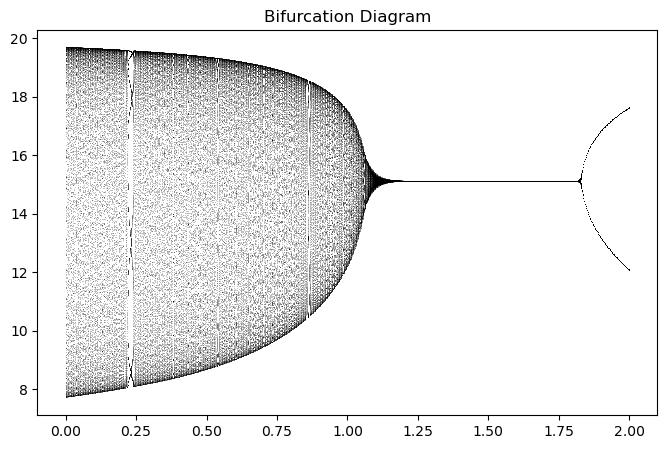

In [19]:
e_values = np.linspace(0, 2, 800)
plot_bifurcation(prices_at_e, e_values, 400, 200)

### Is there a pattern?

Chaotic systems are highly sensitivity to initial conditions and are aperiodic. In the lectures, you've learned about the Lyapunov exponent. Another method to investigate chaotic behaviour is to look for repeating patterns. Specifically we will be looking at the Fast Fourier Transform (FFT) of a time series to identify repeating patterns.

In this approach, we investigate the time series of prices identify dominant frequencies. The presence of dominant frequencies suggests that the system exhibits regular, predictable patterns, indicating it is not chaotic.

Note that the absence of distinct peaks in the frequency domain does not prove that the system is chaotic. This might indicate a lack of periodicity or data, but not definitive evidence of chaos. On the other hand, if we do observe distinct frequency spikes, we can confidently conclude the system exhibits periodic behavior and, therefore, is not chaotic.

In [20]:
from functools import lru_cache

@lru_cache(maxsize=1024)
def extract_fft(f, num_iterations, drop_zero_frequency=True):
    """
    Extracts the Fast Fourier Transform (FFT) of the price sequence.
    
    Args:
        f: The sensitivity parameter for the price sequence.
        num_iterations: The number of iterations to run.
        drop_zero_frequency: Drop zero frequency to make the plot more readable.
    """
    # Generate the price sequence
    burn_in = 100
    price_sequence = prices_at_f(f=f, n_sim=num_iterations+burn_in, m_last=num_iterations)

    # Compute FFT and frequencies
    fft_result = np.fft.fft(price_sequence)
    frequencies = np.fft.fftfreq(num_iterations, 1)

    # Sort the FFT results and frequencies in ascending order
    sorted_indices = np.argsort(frequencies)
    sorted_fft = fft_result[sorted_indices]
    sorted_frequencies = frequencies[sorted_indices]

    # Optionally drop the zero frequency from the results
    if drop_zero_frequency:
        nonzero_indices = sorted_frequencies != 0
        return sorted_frequencies[nonzero_indices], sorted_fft[nonzero_indices]
    else:
        return sorted_frequencies, sorted_fft


In [21]:
def plot_ftt(f):
    # Extract the FFT
    frequencies, fft_result = extract_fft(f=f, num_iterations=400, drop_zero_frequency=True)
    # Plotting the FFT, excluding the zero frequency
    plt.figure(figsize=(7, 4))
    plt.plot(frequencies, np.abs(fft_result), label='Magnitude of FFT')
    plt.xlim(0, 0.5)
    plt.ylim(0, 1500)
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.tight_layout()
    plt.show()


In [22]:
interact(plot_ftt, f=(0, .7, 0.001));

interactive(children=(FloatSlider(value=0.34900000000000003, description='f', max=0.7, step=0.001), Output()),…

### Tip: How to define a recursive function efficiently

**(Useful for next week and Exam)**

To closely align a recursive function with its mathematical definition, we choose to write a recursive function rather than an iterative one. What's the difference? A recursive function is one that calls itself, whereas an iterative function uses a loop to repeat a block of code.

Consider the Fibonacci sequence, defined recursively as:

$$
F_n = F_{n-1} + F_{n-2}
$$

with $F_0 = 0$ and $F_1 = 1$.

Ideally, we'd like to express this as `fibonacci(n) = fibonacci(n-1) + fibonacci(n-2)`. The closest python implementation is a self-calling function, like this:

```python
def fibonacci(n):
    if n == 0:
        return 0
    elif n == 1:
        return 1
    else:
        return fibonacci(n-1) + fibonacci(n-2)
```

Note three things:

- The function calls itself twice for different values of $n$.
- The function includes a base case, i.e., it specifies the return value when $n$ is 0 or 1.
- The function completes its execution only upon reaching this base case.

**Warning:** If the base case is not properly defined or is missed, the function will never terminate, leading to a `RecursionError`.

Running this function with large values of $n$ reveals its inefficiency, as it repeatedly calls itself for the same values of $n$. For instance, computing $F_5$ requires 15 calls, and computing $F_{50}$ requires an astonishing **2,692,537** calls.

However, the function actually needs to call itself only twice for a given $n$ (once for $n-1$ and once for $n-2$). By storing the computed values for each $n$, we can avoid redundant function calls. This technique is known as *memoization*. It can be implemented using the `lru_cache` decorator from the functools package.

By memoizing the last three values, $F_{50}$ can be computed in just 51 calls. 
If in doubt about how many values to memoize, just use a large number like 1000, memory is cheap.

See the code below for the implementation.

In [23]:
from functools import lru_cache

def fib_sequence(n, b=1.0):
    """Computes the nth Fibonacci number, modified by a factor 'b'.
    
    Args:
        n (int): The nth number in the Fibonacci sequence to compute.
        b (float): A multiplier applied to the second term of the Fibonacci sequence.
    
    Returns:
        tuple: The nth Fibonacci number and the number of calls to 'fib'.
    """
    calls = 0  # keeps count of how many times fib is called

    @lru_cache(maxsize=None)  # use default maxsize 128
    def fib(n):
        nonlocal calls  # nonlocal needed to change the value
        calls += 1
        if n <= 1:
            return n
        else:
            return fib(n-1) + fib(n-2) * b

    result = fib(n)
    return result, calls

# Example
fibonacci_number, call_count = fib_sequence(50, 1)
print(f"`fib` was called {call_count} times to obtain F = {fibonacci_number:,}")

`fib` was called 51 times to obtain F = 12,586,269,025
